In [0]:
import sys
import os
from google.colab import drive
drive.mount('/content/gdrive')
default_path = '/content/gdrive/My Drive/PPML/LeNet5/'
save_dir = default_path + 'saves/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ### Implementing LeNet-5 Architecture On MNIST Dataset (GPU Implementation)

import torch
# torch.multiprocessing.set_start_method("spawn")        # https://github.com/pytorch/pytorch/issues/3491#event-1326332533
import torch.nn   
import torch.optim 
import torch.nn.functional 
import torchvision.datasets as datasets
import torchvision.transforms as transforms     

import numpy as np   # this is torch's wrapper for numpy 
import matplotlib
matplotlib.use('Agg')       
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot    
from matplotlib.pyplot import subplot     
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm
import pickle
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)


Using device: cuda:0


In [0]:
# pigi = 1
# def spread_divergence(c,x,b,m,epsilon,bounds=True):
#     ctilde=torch.zeros(len(c))
#     xtilde=torch.zeros(x.shape)
# #     ctilde=np.zeros(len(c))
# #     xtilde=np.zeros(x.shape)
#     x_pixel=torch.zeros((int(784/b**2),len(c)))
#     for n in range(len(c)):
#       if random.random()<pigi:
#         ctilde[n]=c[n]
#       else:
#         ctilde[n]=random.randint(0,10)
#       xtilde[n,:,:]=pixelization(x[n].view(784),b,m,epsilon,bounds)
#     return (ctilde, xtilde)

In [0]:
def Laplace_noise(x,m,epsilon,bounds=True):
  b=1
  if m != 0:
    for i in range(28):
      for j in range(28):
        if random.random()<0.5:
            x[i,j]+=m/(b**2*epsilon)*np.random.exponential()
        else:
            x[i,j]-=m/(b**2*epsilon)*np.random.exponential()
        if bounds:
            x[i,j]=max(0,x[i,j])
            x[i,j]=min(1,x[i,j])
  return x

In [0]:
def prob_xgtx(tx,m,epsilon):
    sigma = m/epsilon
    theta = 0.1306604762738429
    thetaB = torch.zeros(tx.shape)
    for i in range(28):
      for j in range(28):
        A = np.exp(-abs(tx[i,j]-1)/sigma)*theta
        B = np.exp(-abs(tx[i,j])/sigma)*(1-theta)
        thetaB[i,j] = A/(A+B)
    return thetaB

def x_sampling(S,thetaB,label):
  for s in range(S):
    x_rand=torch.rand(thetaB.shape)
    x_rand=x_rand.to(device)
    x_sample=torch.gt(thetaB, x_rand, out=None).float().cuda()
    if s==0:
      x_samples=x_sample.cuda()
    else:
      x_samples=torch.cat([x_samples,x_sample],dim=0).cuda()
  x_samples.requires_grad_(True)
  labels=torch.cat([label]*S,dim=0).cuda()
  return (x_samples,labels)

def sampling_weights(S,labels,outputs):
  weights=torch.zeros(len(labels),requires_grad=False)
  for i in range(int(len(labels)/S)):
    w=torch.zeros(S)
    for s in range(S):
      prob=torch.exp(outputs[i+s*S])
      w[s]=prob[labels[i+s*S]]/torch.sum(prob)
    for s in range(S):
      weights[i+s*S]=w[s]/torch.sum(w)
  return weights

In [0]:
#load noised trainset from Google Drive pickle file
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_noise = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_theta = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# valid = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())  

# create training and validation set indexes (80-20 split)
idx = list(range(len(train)))
np.random.seed(1009)
np.random.shuffle(idx)          
train_valid_ratio = 0.8 #0.8
train_idx = idx[ : int(train_valid_ratio * len(idx))]       
valid_idx = idx[int(train_valid_ratio * len(idx)) : ]

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 26472017.21it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 430503.03it/s]
  1%|          | 16384/1648877 [00:00<00:11, 143170.65it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7480392.42it/s]                           
8192it [00:00, 179640.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
# train_noise.data = train_noise.data.float()
# #add Laplace noise to train set
# train_noise.data = train_noise.data.float()/255

# m = 4
# epsilon = 20
# bounds = False
# for i in tqdm(range(len(train.data))):
#   train_noise.data[i]=Laplace_noise(train_noise.data[i],m,epsilon,bounds)
# with open(save_dir + 'MNIST_trainset_noise.pickle', 'wb') as handle:
#     pickle.dump(train_noise, handle, protocol=pickle.HIGHEST_PROTOCOL)   

100%|██████████| 60000/60000 [27:10<00:00, 36.67it/s]


In [0]:
with open(save_dir + 'MNIST_trainset_noise.pickle', 'rb') as handle:
    train_noise = pickle.load(handle)

In [0]:
# train_theta.data = train_theta.data.float()
# for i in tqdm(range(len(train_noise.data))):
#   train_theta.data[i]=prob_xgtx(train_noise.data[i],4,20)
# with open(save_dir + 'MNIST_trainset_theta.pickle', 'wb') as handle:
#     pickle.dump(train_theta, handle, protocol=pickle.HIGHEST_PROTOCOL)   

 42%|████▏     | 25393/60000 [59:58<1:20:09,  7.20it/s]

In [0]:
# train_theta = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
with open(save_dir + 'MNIST_trainset_theta.pickle', 'rb') as handle:
    train_theta = pickle.load(handle)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9f5ea55a90>,
 <matplotlib.image.AxesImage at 0x7f9f5e9b52b0>)

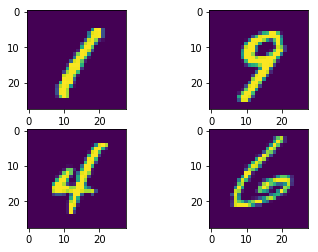

In [0]:
# sample images
fig1 = train.data[3].numpy()  
fig2 = train.data[2501].numpy()
fig3 = train.data[25001].numpy()  
fig4 = train.data[59998].numpy()
subplot(2,2,1), pyplot.imshow(fig1)  
subplot(2,2,2), pyplot.imshow(fig2) 
subplot(2,2,3), pyplot.imshow(fig3)
subplot(2,2,4), pyplot.imshow(fig4)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9f5c916f28>,
 <matplotlib.image.AxesImage at 0x7f9f5c86fcf8>)

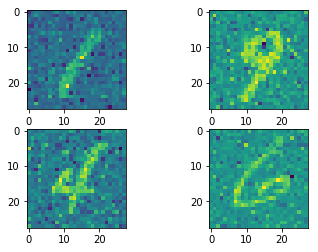

In [0]:
# sample images
fig1 = train_noise.data[3].numpy()  
fig2 = train_noise.data[2501].numpy()
fig3 = train_noise.data[25001].numpy()  
fig4 = train_noise.data[59998].numpy()
subplot(2,2,1), pyplot.imshow(fig1)  
subplot(2,2,2), pyplot.imshow(fig2) 
subplot(2,2,3), pyplot.imshow(fig3)
subplot(2,2,4), pyplot.imshow(fig4)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9f5c7b4a58>,
 <matplotlib.image.AxesImage at 0x7f9f5c789828>)

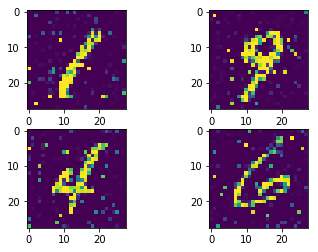

In [0]:
fig1 = train_theta.data[3].numpy()  
fig2 = train_theta.data[2501].numpy()
fig3 = train_theta.data[25001].numpy()  
fig4 = train_theta.data[59998].numpy()
subplot(2,2,1), pyplot.imshow(fig1)  
subplot(2,2,2), pyplot.imshow(fig2) 
subplot(2,2,3), pyplot.imshow(fig3)
subplot(2,2,4), pyplot.imshow(fig4)

In [0]:
(x_samples,labels) = x_sampling(2,train_theta.data[3].to(device),torch.tensor([1]))

In [0]:
print(x_samples[0])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SelectBackward>)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f9fce4800b8>,
 <matplotlib.image.AxesImage at 0x7f9f5b130cc0>)

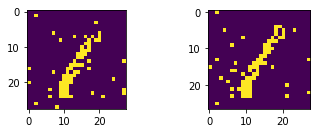

In [0]:
fig1 = x_samples[0:28].cpu().detach().numpy() 
fig2 = x_samples[29:56].cpu().detach().numpy()
subplot(2,2,1), pyplot.imshow(fig1)  
subplot(2,2,2), pyplot.imshow(fig2)  


In [0]:
# In[4]:

# generate training and validation set samples
train_set = torch.utils.data.sampler.SubsetRandomSampler(train_idx)    
valid_set = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)  

# Load training and validation data based on above samples
# Size of an individual batch during training and validation is 30
# Both training and validation datasets are shuffled at every epoch by 'SubsetRandomSampler()'. Test set is not shuffled.

theta_loader = torch.utils.data.DataLoader(train_theta, batch_size=128, sampler=train_set, num_workers=4)
train_loader = torch.utils.data.DataLoader(train, batch_size=32, sampler=train_set, num_workers=4)
valid_loader = torch.utils.data.DataLoader(train, batch_size=32, sampler=valid_set, num_workers=4)    
test_loader = torch.utils.data.DataLoader(test, num_workers=4)       


In [0]:
# Defining the network (LeNet-5)  
class LeNet5(torch.nn.Module):          
     
    def __init__(self):     
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2) 
        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = torch.nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv1(x))  
        # max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        return x

def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)


In [0]:
net = LeNet5()
net.apply(weights_init_normal)
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

epoch:  0 , loss:  tensor(2.2825, device='cuda:0')
train  0.10489583333333333
validation  0.1025
epoch:  1 , loss:  tensor(2.1248, device='cuda:0')
train  0.022375
validation  0.021416666666666667
epoch:  2 , loss:  tensor(2.0036, device='cuda:0')
train  0.076375
validation  0.07583333333333334
epoch:  3 , loss:  tensor(1.9665, device='cuda:0')
train  0.06475
validation  0.06391666666666666
epoch:  4 , loss:  tensor(1.9491, device='cuda:0')
train  0.10258333333333333
validation  0.09958333333333333


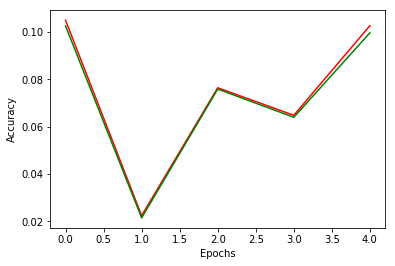

In [0]:
loss_func = torch.nn.CrossEntropyLoss()
optimization = torch.optim.SGD(net.parameters(), lr = 0.1, momentum=0.9) #replace this
# In[7]:

# Let training begin!
numEpochs = 5
training_accuracy = []     
validation_accuracy = []

for epoch in range(numEpochs):
    # training set -- perform model training
    epoch_training_loss = 0.0
    num_batches = 0
    for batch_num, (samples, labels) in enumerate(theta_loader):        # 'enumerate' is a super helpful function
        samples, labels = samples.to(device), labels.to(device)
        # Make gradients zero for parameters 'W', 'b'
        optimization.zero_grad()    

        forward_output = net(samples)
        loss = loss_func(forward_output,labels)
        
        loss.backward()
        optimization.step()     #replace with written rule

        # calculating loss 
        epoch_training_loss += loss.data
        num_batches += 1
        
    print("epoch: ", epoch, ", loss: ", epoch_training_loss/num_batches)      
    
    # calculate training set accuracy
    accuracy = 0.0 
    num_batches = 0
    for batch_num, training_batch in enumerate(train_loader):        # 'enumerate' is a super helpful function        
        num_batches += 1
        inputs, actual_val = training_batch
        # perform classification
        predicted_val = net(torch.autograd.Variable(inputs.cuda()))
        # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
        predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
        predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
        # accuracy   
        accuracy += accuracy_score(actual_val.numpy(), predicted_val)
    print('train ',accuracy/num_batches)
    training_accuracy.append(accuracy/num_batches)  
      
    # calculate validation set accuracy 
    accuracy = 0.0 
    num_batches = 0
    for batch_num, validation_batch in enumerate(valid_loader):        # 'enumerate' is a super helpful function        
        num_batches += 1
        inputs, actual_val = validation_batch
        # perform classification
        predicted_val = net(torch.autograd.Variable(inputs.cuda()))    
        # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
        predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
        predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
        # accuracy        
        accuracy += accuracy_score(actual_val.numpy(), predicted_val)
    print("validation ",accuracy/num_batches)
    validation_accuracy.append(accuracy/num_batches)
    
epochs = list(range(numEpochs))

# plotting training and validation accuracies
fig1 = pyplot.figure()
pyplot.plot(epochs, training_accuracy, 'r')
pyplot.plot(epochs, validation_accuracy, 'g')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy") 
pyplot.show(fig1)

In [0]:
# In[6]:

# set up loss function -- 'SVM Loss' a.k.a 'Cross-Entropy Loss'

loss_func = torch.nn.CrossEntropyLoss()#reduction='sum'

# def loss_func(outputs,labels,weights):
# #     loss=torch.zeros(1,requires_grad=True)
#     loss=-weights[0]*torch.nn.functional.log_softmax(outputs[0])[labels[0]]
#     for i in range(1,len(outputs)):
#       loss-=weights[i]*torch.nn.functional.log_softmax(outputs[i])[labels[i]]
#     return loss

  
  
  
# SGD used for optimization, momentum update used as parameter update  
optimization = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum=0.5,nesterov=True) #replace this
# optimization=torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [0]:
# In[7]:

# Let training begin!
numEpochs = 200  
training_accuracy = []     
validation_accuracy = []
S=32

for epoch in range(numEpochs):
    epoch_one = time.time()
    # training set -- perform model training
    epoch_training_loss = 0.0
    num_batches = 0
    for batch_num, (thetaB, labels) in enumerate(theta_loader):        # 'enumerate' is a super helpful function
        thetaB, labels = thetaB.to(device), labels.to(device)
#         print(thetaB)
#         thetaB.requires_grad_(True)
        # split training data into inputs and labels
        (x_samples,labels)=x_sampling(S, thetaB, labels)
        
        # Make gradients zero for parameters 'W', 'b'
        optimization.zero_grad()         
        
#         # forward, backward pass with parameter update
        forward_output = net(x_samples)
#         weights=sampling_weights(S, labels, forward_output).cuda()
        loss = loss_func(forward_output,labels)

#         forward_output = net(x_samples)
#         loss = loss_func(forward_output,labels)
        
        loss.backward()
        optimization.step()     #replace with written rule

        # calculating loss 
        epoch_training_loss += loss.data
        num_batches += 1
    epoch_two = time.time()
    print("epoch: ", epoch, ", loss: ", epoch_training_loss/num_batches," , {0} seconds".format(epoch_two - epoch_one))            
    
    if epoch%10==0:
      # calculate training set accuracy
      accuracy = 0.0 
      num_batches = 0
      for batch_num, training_batch in enumerate(train_loader):        # 'enumerate' is a super helpful function        
          num_batches += 1
          inputs, actual_val = training_batch
          # perform classification
          predicted_val = net(torch.autograd.Variable(inputs.cuda()))
          # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
          predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
          predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
          # accuracy   
          accuracy += accuracy_score(actual_val.numpy(), predicted_val)
      epoch_three = time.time()
      print('train ',accuracy/num_batches," , {0} seconds".format(epoch_three - epoch_two))
      training_accuracy.append(accuracy/num_batches)  

      # calculate validation set accuracy 
      accuracy = 0.0 
      num_batches = 0
      for batch_num, validation_batch in enumerate(valid_loader):        # 'enumerate' is a super helpful function        
          num_batches += 1
          inputs, actual_val = validation_batch
          # perform classification
          predicted_val = net(torch.autograd.Variable(inputs.cuda()))    
          # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
          predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
          predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
          # accuracy        
          accuracy += accuracy_score(actual_val.numpy(), predicted_val)
      epoch_four = time.time()
      print("validation ",accuracy/num_batches," , {0} seconds".format(epoch_four - epoch_three))
      validation_accuracy.append(accuracy/num_batches)


epoch:  0 , loss:  tensor(2.3085, device='cuda:0')  , 25.585217237472534 seconds
train  0.09154166666666666  , 6.8525612354278564 seconds
validation  0.09083333333333334  , 1.7802000045776367 seconds
epoch:  1 , loss:  tensor(2.3072, device='cuda:0')  , 25.805394172668457 seconds
epoch:  2 , loss:  tensor(2.3062, device='cuda:0')  , 25.659866094589233 seconds
epoch:  3 , loss:  tensor(2.3055, device='cuda:0')  , 25.6698260307312 seconds
epoch:  4 , loss:  tensor(2.3049, device='cuda:0')  , 25.504146337509155 seconds
epoch:  5 , loss:  tensor(2.3044, device='cuda:0')  , 25.575047254562378 seconds
epoch:  6 , loss:  tensor(2.3040, device='cuda:0')  , 25.480453729629517 seconds
epoch:  7 , loss:  tensor(2.3037, device='cuda:0')  , 25.580931663513184 seconds
epoch:  8 , loss:  tensor(2.3034, device='cuda:0')  , 25.553130388259888 seconds
epoch:  9 , loss:  tensor(2.3031, device='cuda:0')  , 25.388654232025146 seconds
epoch:  10 , loss:  tensor(2.3029, device='cuda:0')  , 25.420491933822632

In [0]:
10%10

0

In [0]:
accuracy = 0.0 
num_batches = 0
for batch_num, validation_batch in enumerate(valid_loader):        # 'enumerate' is a super helpful function        
    num_batches += 1
    inputs, actual_val = validation_batch
    # perform classification
    predicted_val = net(torch.autograd.Variable(inputs.cuda()))    
    # convert 'predicted_val' tensor to numpy array and use 'numpy.argmax()' function    
    predicted_val = predicted_val.cpu().data.numpy()    # convert cuda() type to cpu(), then convert it to numpy
    predicted_val = np.argmax(predicted_val, axis = 1)  # retrieved max_values along every row    
    # accuracy        
    accuracy += accuracy_score(actual_val.numpy(), predicted_val)
validation_accuracy.append(accuracy/num_batches)

In [0]:
print(validation_accuracy)

[0.11692592592592378]


In [0]:

epochs = list(range(numEpochs))

# plotting training and validation accuracies
fig1 = pyplot.figure()
pyplot.plot(epochs, training_accuracy, 'r')
pyplot.plot(epochs, validation_accuracy, 'g')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy") 
pyplot.show(fig1)


In [0]:
# In[9]:

# test the model on test dataset
correct = 0
total = 0
for test_data in test_loader:
    total += 1
    inputs, actual_val = test_data 
    # perform classification
    predicted_val = net(torch.autograd.Variable(inputs.cuda()))   
    # convert 'predicted_val' GPU tensor to CPU tensor and extract the column with max_score
    predicted_val = predicted_val.cpu().data
    max_score, idx = torch.max(predicted_val, 1)
    # compare it with actual value and estimate accuracy
    correct += (idx == actual_val).sum()
       
print("Classifier Accuracy: ", correct/total * 100)